## Table of Contents
1. [Preparation](#preparation)
    * [Imports](#imports)
    * [Constants](#constants)
2. [Oracle](#oracle)
3. [Diffuser](#diffuser)
4. [Grover's Algorithm](#grovers-algorithm)
5. [Density Matrix](#density-matrix)
    * [City Plot](#city-plot)
    * [Bloch Sphere](#bloch-sphere)
    * [Hinton Plot](#hinton-plot)
    * [Q-Sphere](#q-sphere)
6. [References](#references)

## Preparation

This is required before implementing Grover's algorithm to ensure that everything runs successfully.

### Imports

In [1]:
from qiskit import QuantumCircuit as qc
from qiskit import QuantumRegister as qr
from qiskit import execute
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from math import pi, sqrt
from heapq import nlargest

### Constants
$n$, `SHOTS` $\in \mathbb{Z^{+}}$

$\{\,x \in$ `SEARCH_VALUES` $\mid x \in \mathbb{N}, 0 \le x \lt 2^{n}\,\}$

In [2]:
"""Feel free to modify the following constants"""
N = 5                          # Number of qubits
SEARCH_VALUES = {9, 0, 3, 19}  # Set of m nonnegative integers to search for using Grover's algorithm (i.e. TARGETS in base 10)
SHOTS = 10000                  # Amount of times the algorithm is simulated

"""Please do not modify the following constants, otherwise you risk breaking the program"""
TARGETS = {f"{s:0{N}b}" for s in SEARCH_VALUES}  # Set of m N-qubit binary strings representing target state(s) (i.e. SEARCH_VALUES in base 2)
QUBITS = qr(N, "q")                              # N-qubit quantum register

## Oracle

Oracle $U_{w}$ flips the sign(s) of $n$-qubit target state(s) while leaving all other orthogonal states unchanged.

$U_{w} = X(MCZ)X$

Pauli-X gate $X$ is applied to qubit $|q_{i} \rangle$ if $q_{i} = 0$ in target state $|q_{n - 1}, \ldots, q_{0} \rangle$. After $X$ is applied to the appropriate qubit(s), target state is transformed to $|1 \rangle^{\otimes n}$. Then $(n − 1)$-control Z gate $MCZ$ flips the sign of $|1 \rangle^{\otimes n}$.

We simulate $MCZ$ by applying Hadamard gate $H$, $(n - 1)$-control Toffoli gate $MCT$, and another $H$ to qubit $|q_{n - 1}\rangle$:

$MCZ = H(MCT)H$

Finally, $X$ is applied again to the appropriate qubit(s) to reverse the transformation by the first $X$. This entire process is applied to all target state(s), which we've implemented in `oracle()`:

$U_{w} = XH(MCT)HX$

In [3]:
def oracle(targets: set[str], name: str = "Oracle") -> qc:
    """Mark target state(s) with negative phase.

    Args:
        targets (set[str]): N-qubit binary string(s) representing target state(s).
        name (str, optional): Quantum circuit's name. Defaults to "Oracle".

    Returns:
        qc: Quantum circuit representation of oracle.
    """
    # Create N-qubit quantum circuit for oracle
    oracle = qc(QUBITS, name = name)

    for target in targets:
        # Reverse target state since Qiskit uses little-endian for qubit ordering
        target = target[::-1]
        
        # Flip zero qubits in target
        for i in range(N):
            if target[i] == "0":
                oracle.x(i)                    # Pauli-X gate

        # Simulate (N - 1)-control Z gate
        oracle.h(N - 1)                        # Hadamard gate
        oracle.mcx(list(range(N - 1)), N - 1)  # (N - 1)-control Toffoli gate
        oracle.h(N - 1)                        # Hadamard gate

        # Flip back to original state
        for i in range(N):
            if target[i] == "0":
                oracle.x(i)                    # Pauli-X gate

    return oracle

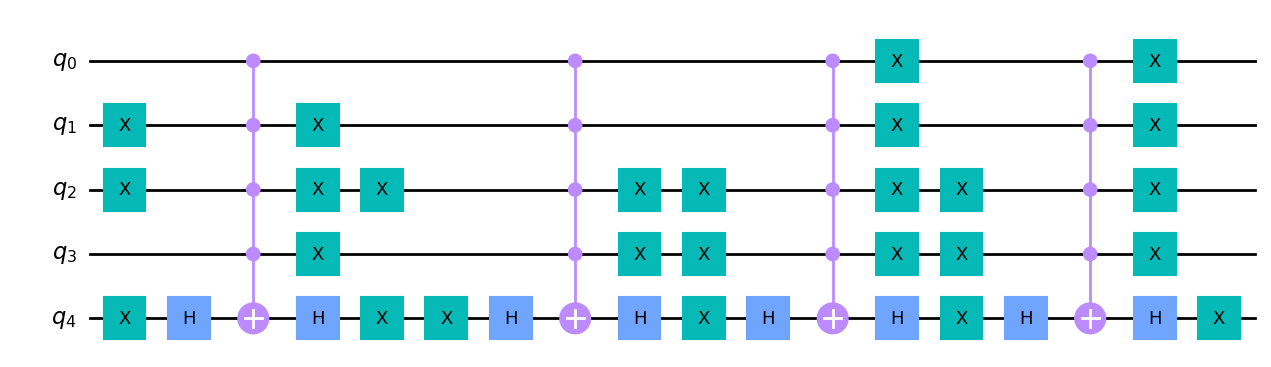

In [4]:
# Generate and display quantum circuit for oracle
grover_oracle = oracle(TARGETS)
grover_oracle.draw("mpl")

## Diffuser

Diffuser $D$ amplifies the target state(s) (which deamplifies all other states) with a reflection about the average amplitude. In other words, it increases the probability of getting the $n$-qubit target state(s) marked by $U_{w}$ and, ultimately, the right answer.

$D = H^{\otimes n}U_{0}H^{\otimes n}$

We create $D$ by applying $H^{\otimes n}$, $U_{w}$ with its target state $w$ set to $|0 \rangle^{\otimes n}$, and $H^{\otimes n}$ again to each qubit. This leaves us with the final equation we've implemented in `diffuser()`:

In [5]:
def diffuser(name: str = "Diffuser") -> qc:
    """Amplify target state(s) amplitude, which decreases the amplitudes of other states
    and increases the probability of getting the correct solution (i.e. target state(s)).

    Args:
        name (str, optional): Quantum circuit's name. Defaults to "Diffuser".

    Returns:
        qc: Quantum circuit representation of diffuser (i.e. Grover's diffusion operator).
    """
    # Create N-qubit quantum circuit for diffuser
    diffuser = qc(QUBITS, name = name)
    
    diffuser.h(QUBITS)                          # Hadamard gate
    diffuser.append(oracle(["0" * N]), QUBITS)  # Oracle with all zero target state
    diffuser.h(QUBITS)                          # Hadamard gate
    
    return diffuser

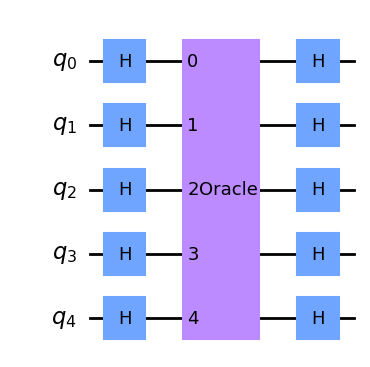

In [6]:
# Generate and display quantum circuit for diffuser
grover_diffuser = diffuser()
grover_diffuser.draw("mpl")

## Grover's Algorithm

Grover's algorithm, also known as quantum search algorithm, finds $m$ target(s) within a database of size $N$; this is particularly useful for unstructured searches. A search is performed by evaluating a function (i.e. $U_{w}$) that returns a particular value for the target(s) and another value for all other objects in the database. More generally, it solves the problem of function inversion: Given $y = f(x)$ where $x$ can take $N$ values, Grover's algorithm finds the value $x = f^{−1}(y)$ with $O(\sqrt{N})$ evaluations; a naïve exhaustive search (i.e. classical algorithm) would require about $O(N)$ evaluations. This is a significant, quadratric speed-up!

$m, N \in \mathbb{Z^{+}}$

The first step of the algorithm involves encoding all objects of the database as orthogonal states. That is, initializing all $n$ qubits to $|0 \rangle$. Assuming maximum uncertainty about the $n$-qubit target state(s), the initial state is chosen to be the uniform superposition $|s \rangle$ of all basis states:

$|s \rangle = (H|0 \rangle)^{\otimes n}$

We do this by applying $H$ on all qubits. Afterwards, we increase the likelihood of detecting the target state(s) at the end by applying $U_{w}$ followed by $D$ (also known as Grover operator) to $|s \rangle$ an optimal amount of times $t$. After $t$ iterations, the state(s) will have transformed to $|\psi_{t} \rangle$:

$|\psi_{t} \rangle = (DU_{w})^{t}|s \rangle$

Where:

$t \in \mathbb{Z^{+}}$

$t \approx \lfloor \frac{\pi}{4} \sqrt{\frac{N}{m}}\rfloor$

In this case, $N = 2^{n}$, so $t$ can be simplified:

$t \approx \lfloor \frac{\pi}{4} \sqrt{\frac{2^{n}}{m}}\rfloor$

The final step involves measuring $|\psi_{t} \rangle$, which should return the target state(s) with near-certainty (i.e. probability very close to $1$).

In [7]:
def grover(name: str = "Grover Circuit") -> qc:
    """Create quantum circuit representation of Grover's algorithm,
    which consists of 4 parts: (1) state preparation/initialization,
    (2) oracle, (3) diffuser, and (4) measurement of resulting state.
    
    Steps 2-3 are repeated an optimal number of times (i.e. Grover's
    iterate) in order to maximize probability of success of Grover's algorithm.

    Args:
        name (str, optional): Quantum circuit's name. Defaults to "Grover Circuit".

    Returns:
        qc: Quantum circuit representation of Grover's algorithm.
    """
    # Create N-qubit quantum circuit for Grover's algorithm
    grover = qc(QUBITS, name = name)
    
    # Intialize qubits with Hadamard gate (i.e. uniform superposition)
    grover.h(QUBITS)
    
    # Apply barrier to separate steps
    grover.barrier()
    
    # Apply oracle and diffuser (i.e. Grover operator) optimal number of times
    for _ in range(int((pi / 4) * sqrt((2 ** N) / len(TARGETS)))):
        grover.append(grover_oracle, QUBITS)
        grover.append(grover_diffuser, QUBITS)
     
    # Measure all qubits once finished
    grover.measure_all()
    
    return grover

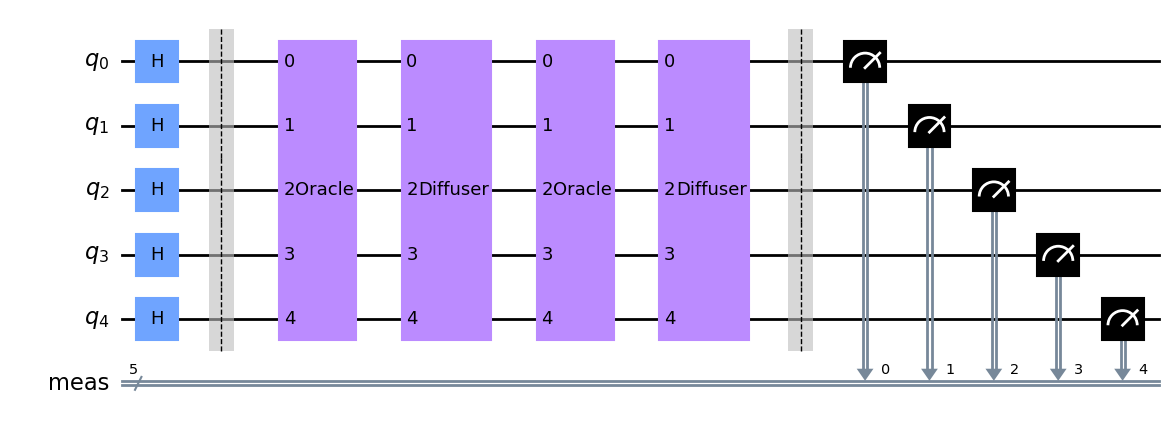

In [8]:
# Generate and display quantum circuit for Grover's algorithm 
grover_circuit = grover()
grover_circuit.draw("mpl")

In [9]:
def outcome(winners: list[str], frequencies: set[int]) -> None:
    """Print top measurement(s) (state(s) with highest frequency)
    and target state(s) in binary and decimal form, determine
    if top measurement(s) equals target state(s), then print result.

    Args:
        winners (list[str]): State(s) (N-qubit binary string(s))
        with highest probability of being measured.
        frequencies (set[int]): Number of times winner(s) were measured.
    """
    print("WINNER(S):")
    print(f"Binary = {winners}\nDecimal = {[int(key, 2) for key in winners]}\n")
        
    print("TARGET(S):")
    print(f"Binary = {TARGETS}\nDecimal = {SEARCH_VALUES}\n")
    
    print(f"Target(s) found with {sum(frequencies) / SHOTS:.2%} accuracy!"
          if all(key in TARGETS for key in winners)
          else "Target(s) not found...")

In [10]:
# Save density matrix of final state
grover_circuit.save_density_matrix()

# Simulate Grover's algorithm with grover_circuit SHOTS times and get results
results = execute(grover_circuit, backend = Aer.get_backend("qasm_simulator"), shots = SHOTS).result()

# Get each state's frequency
counts = results.get_counts()

# Find winner(s) (i.e. state(s) with highest count)
winners = nlargest(len(TARGETS), counts, key = counts.get)

# Print outcome
outcome(winners, {counts.get(winner) for winner in winners})

WINNER(S):
Binary = ['00011', '01001', '00000', '10011']
Decimal = [3, 9, 0, 19]

TARGET(S):
Binary = {'01001', '00011', '10011', '00000'}
Decimal = {0, 9, 3, 19}

Target(s) found with 94.75% accuracy!


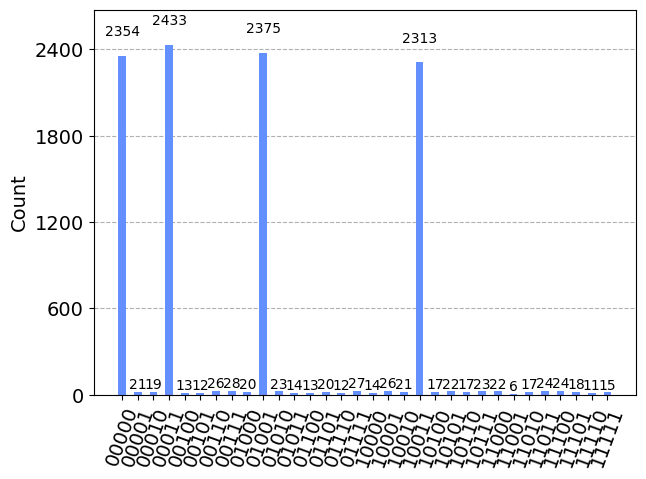

In [11]:
# Display simulation results as histogram
plot_histogram(counts)

## Density Matrix

Density matrix is a collection of numbers in a matrix used to describe $n$-qubit state(s) in a system. In our case, `density_matrix` represents $m$ winner(s) (which should equal our target state(s)), and is visualized in the diagrams below.

In [12]:
# Generate density matrix representation from results of grover_circuit simulations
density_matrix = results.data()["density_matrix"]

### City Plot

City plot is made up of two 3D bar graphs representing the real and imaginary parts of an $n$-qubit state. Each bar's length is proportional to the magnitude of the corresponding number.

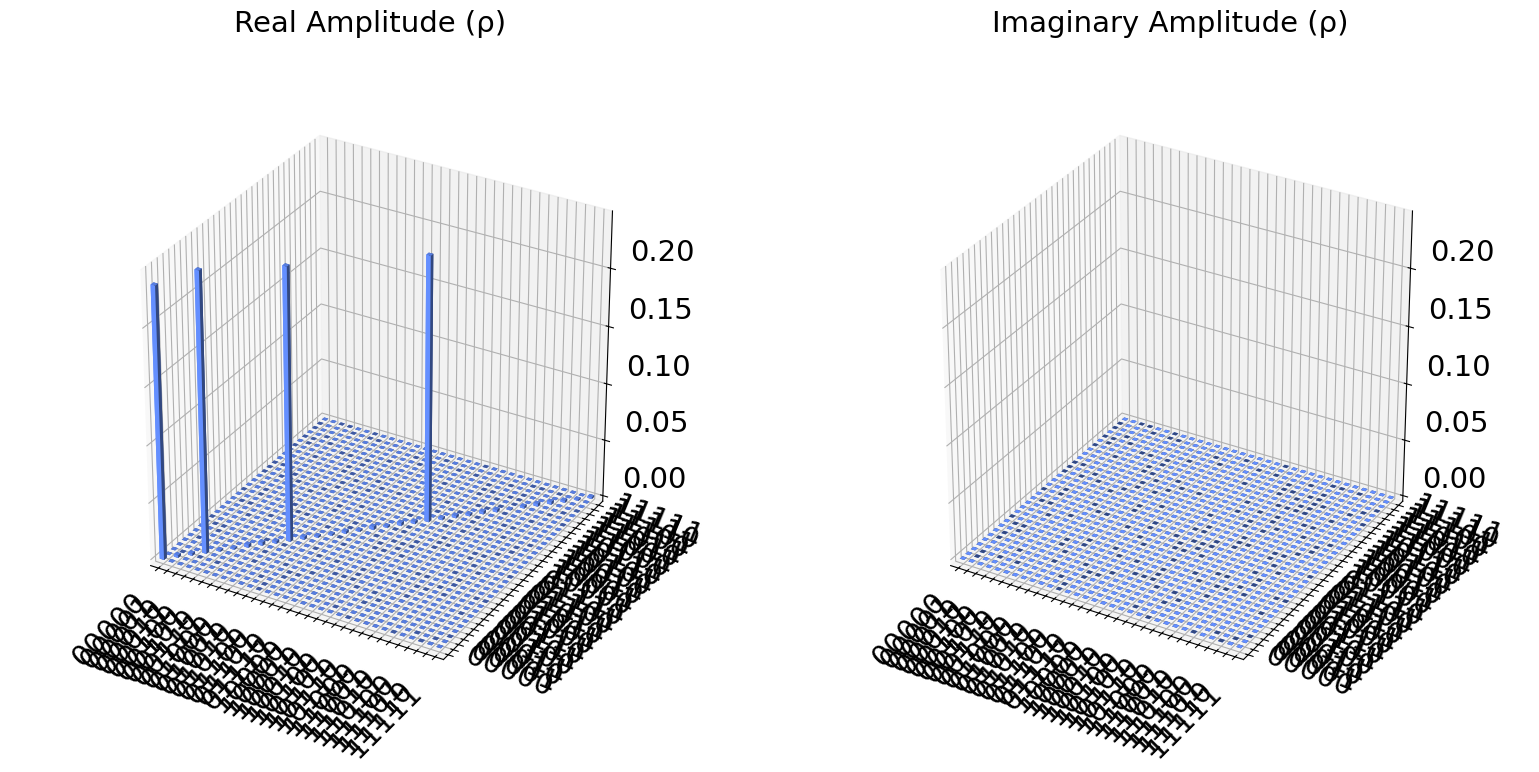

In [13]:
# City plot of density_matrix
density_matrix.draw("city")

### Bloch Sphere

Bloch sphere is a 3D geometric representation of a single qubit's state. A point $(\theta, \phi)$ on the sphere's surface denotes a pure state, represented by state vector $|\psi \rangle$, with its north and south poles corresponding to $|0 \rangle$ and $|1 \rangle$ respectively. This means that we can always say for certain (100% probability) that our system's in state $|\psi \rangle$. In other words, for a pure state we have complete knowledge of the system and know exactly what state it's in.

$|\psi \rangle = \alpha|0 \rangle + \beta|1 \rangle$

Probability amplitudes $\alpha$ and $\beta$ can be real or complex numbers.

$\alpha = cos(\frac{\theta}{2})$

$\beta = e^{i \phi} sin(\frac{\theta}{2})$

$\theta, \phi \in \mathbb{R}$ where $0 \le \theta \le \pi$ and $0 \le \phi \le 2\pi$.

The probability of obtaining $|0 \rangle$ and $|1 \rangle$ after measurement is $|\alpha|^{2}$ and $|\beta|^{2}$ respectively, hence the total probability of the system being observed in $|0 \rangle$ or $|1 \rangle$ is 1:

$|\alpha|^{2} + |\beta|^{2} = 1$

A point inside the sphere denotes a mixed state, represented by density matrix $\hat{\rho}$, which is a probability distribution of different pure states, with a maximally mixed state at the sphere's center (equal probabilities of being observed in $|0 \rangle$ or $|1 \rangle$). $\hat{\rho}$ is a generalized version of a state vector and is used to represent the system when we're uncertain of its state.

$\hat{\rho} = \sum\limits_{k}^{N} p_{k} |\psi_{k} \rangle \langle\psi_{k}| =
\displaystyle\frac{1}{2} \begin{bmatrix}1 + r_{z} & r_{x} - ir_{y} \\ r_{x} + ir_{y} & 1 - r_{z}\end{bmatrix}$

Weights $p_{k}$ can be interpreted as the probability of the system being in state $|\psi_{k} \rangle$ where $0 \lt p_{k} \le 1$. Note: $\hat{\rho}$ of a pure state naturally reduces to $|\psi \rangle$ with $p = 1$.

$N$ is the total number of possible states the system could be in with $\sum\limits_{k}^{N} p_{k} = 1$.

$|\psi_{k} \rangle \langle\psi_{k}|$ represents the outer product of the state $|\psi_{k} \rangle$ with itself, producing a matrix known as the projection operator $\hat{P}_{\psi_{k}}$.

Coefficients $r_{x}, r_{y}, r_{z}$ are components of the vector representing a mixed state, known as the Bloch vector $\vec{r}$.

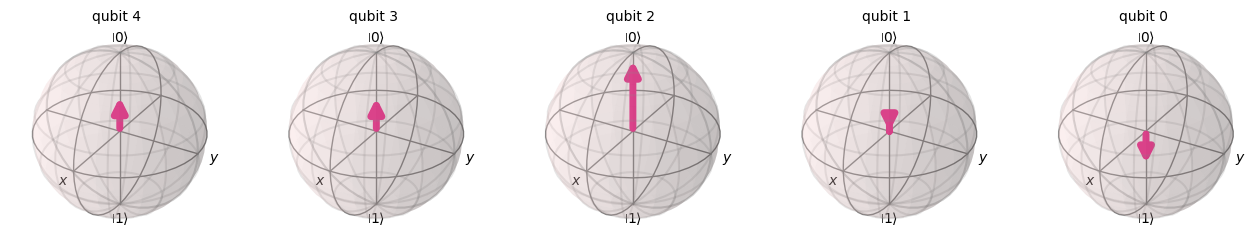

In [14]:
# Bloch sphere representation of density_matrix
# reverse_bits = True since Qiskit uses little-endian for qubit ordering
density_matrix.draw("bloch", reverse_bits = True)

### Hinton Plot

Hinton plot represents the real and imaginary parts of $n$-qubit state(s) on 2D plots by using squares. Positive and negative values are represented by white and black squares respectively, and the size of each square represents the magnitude of each value.

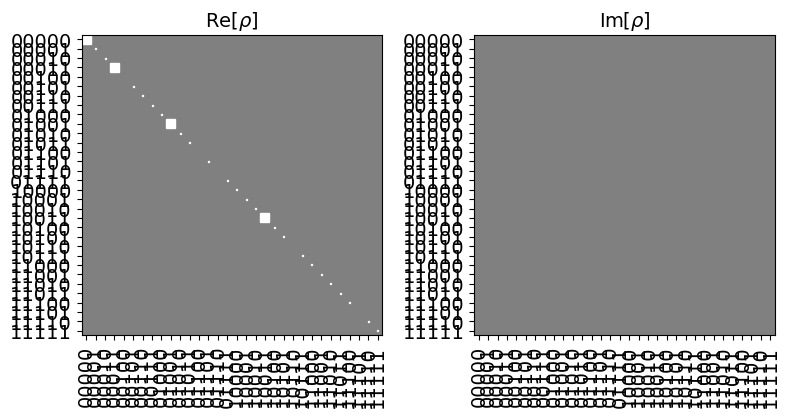

In [15]:
# Hinton plot of density_matrix
density_matrix.draw("hinton")

### Q-Sphere

Q-Sphere is a visualization of $n$-qubit state(s) that associates each computational basis state with a point on the surface of a sphere. A node is visible at each point; each node's radius is proportional to the probability $p_{k}$ of its basis state, whereas the node color indicates its phase $\varphi_{k}$. The sphere's north and south poles correspond to basis states $|0 \rangle^{\otimes n}$ and $|1 \rangle^{\otimes n}$ respectively, with all other basis states in between. Beginning at the north pole and progressing southward, each successive latitude has basis states with a greater number of $1$'s; a basis state's latitude is determined by its Hamming distance from $|0 \rangle^{\otimes n}$. The vector(s) on the sphere represents the system's density matrix.

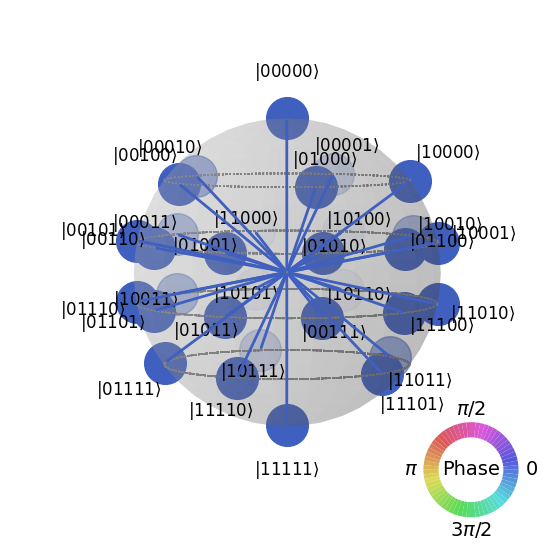

In [16]:
# Qsphere representation of density_matrix
density_matrix.draw("qsphere")

## References

* [Grover's Search Algorithm for $n$ Qubits with Optimal Number of Iterations](https://arxiv.org/pdf/2011.04051.pdf)
* [Grover's Algorithm and Amplitude Amplification](https://qiskit.org/documentation/tutorials/algorithms/06_grover.html)
* [Grover's Algorithm](https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm)
* [Theory of Grover's Search Algorithm](https://learn.microsoft.com/en-us/azure/quantum/concepts-grovers)
* [Representing Qubit States](https://learn.qiskit.org/course/ch-states/representing-qubit-states)
* [Qubit](https://www.quantiki.org/wiki/qubit)
* [Bloch Sphere](https://mathworld.wolfram.com/BlochSphere.html)
* [The More You Know: Bloch Sphere](https://entangledphysics.com/2016/03/23/the-more-you-know-bloch-sphere/)
* [Quantum State Tomography](http://research.physics.illinois.edu/QI/Photonics/tomography-files/tomo_chapter_2004.pdf)
* [Hinton Diagrams](https://matplotlib.org/stable/gallery/specialty_plots/hinton_demo.html)
* [Visualizations: Q-Sphere View](https://quantum-computing.ibm.com/composer/docs/iqx/visualizations#q-sphere-view)
* [Quantum Computing Primer: Pure and Mixed States](https://techcommunity.microsoft.com/t5/educator-developer-blog/quantum-computing-primer-pure-and-mixed-states/ba-p/380514)
* [Mixed States and Pure States](https://pages.uoregon.edu/svanenk/solutions/Mixed_states.pdf)
* [The Density Matrix and Mixed States](https://learn.qiskit.org/course/quantum-hardware/density-matrix)
* [Mixed States and Measurement](https://www.cs.cmu.edu/~odonnell/quantum15/lecture16.pdf)
* [Introduction to Quantum Computing: Grover's Algorithm](https://akyrillidis.github.io/notes/quant_post_9)